In [268]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### read image as np array

In [269]:
def read_img(img_name):
  tubes_img = Image.open(img_name)
  # resize image to the fixed size
  tubes_img = tubes_img.resize((288, 512))
  # original image is write protected so need to make a copy
  tubes_img = np.array(tubes_img).copy()
  # crop the top part of the image
  tubes_img = tubes_img[80:480]
  tubes_img = tubes_img.astype("float") / 255
  return tubes_img

### get colors between the tubes

In [270]:
def get_tubes(tubes_img):
  height, width, channels = tubes_img.shape
  tubes = []
  tube_indx = 0
  n_tubes = 0

  for i in range(height):
    tube_start=False; tube_end=False
    tube_seq="outside"
    found = False
    for j in range(width):
      if (tube_seq=="outside") and (np.mean(tubes_img[i,j]) > .785):
        tube_seq="start"
      elif (tube_seq=="start") and (np.mean(tubes_img[i,j]) <= .785):
        tube_start = j
        tube_seq="inside"
      elif (tube_seq=="inside") and (np.mean(tubes_img[i,j]) > .785):
          tube_end = j-1
          tube_seq="end"
      elif (tube_seq=="end") and (np.mean(tubes_img[i,j]) <= .785):
          tube_seq="outside"

      if (tube_seq=="outside") and tube_end:
        tube_width = tube_end - tube_start
        if (tube_width < 40) and (tube_width > 20):
          mid = (tube_start + tube_end)//2
          mid_colr = tubes_img[i,mid]
          found = True
          colr = list(mid_colr)
          if tube_indx < len(tubes):
            tubes[tube_indx].append(colr)
          else:
            tubes.append([colr])
          tube_indx += 1

        tube_start=False; tube_end=False
    # end width loop      
    if found:
      tube_indx = n_tubes
    else:
      n_tubes = len(tubes)
      tube_indx = n_tubes

  return tubes    

In [271]:
def rem_nonTubes(tubes):
  mean_tubeLen = np.mean([len(tube) for tube in tubes])
  #print(mean_tubeLen)
  new_tubes = []
  for tube in tubes:
    #print(len(tube) - mean_tubeLen)
    if (len(tube)-mean_tubeLen > 0) or (mean_tubeLen-len(tube) < mean_tubeLen/10):
      new_tubes.append(tube)
  return new_tubes

In [272]:
def get_patchColrs(tubes):
  new_tubes = []
  for tube in tubes:
    new_tube = []
    tube_step = int(len(tube)/4)    
    for i in range(4):
      start = i*tube_step
      stop = start+tube_step
      colrs = tube[start:stop]
      # get colr with max freq
      counter = 0
      colr = colrs[0]
      for i in colrs:
          curr_frequency = colrs.count(i)
          if curr_frequency > counter:
              counter = curr_frequency
              colr = i
      colr = [1,1,1] if np.mean(colr)<0.2 else colr
      new_tube.append(colr)
    new_tubes.append(new_tube)
  return new_tubes

In [321]:
def equalize_colrs(tubes):
  # get all colrs
  colrs = []
  
  for tube in tubes:
    for colr1 in tube:
      if colr1 not in colrs:
        colr_exists = False
        # check for approximately equal colors
        for colr2 in colrs:
          if np.allclose(colr1,colr2,atol=0.1):
            colr_exists = True
            break
        if not colr_exists:
          colrs.append(colr1)

  # replace approximately equal colors
  new_tubes = []
  for tube in tubes:
    new_tube = []
    for colr1 in tube:
      for colr2 in colrs:
        if np.allclose(colr1,colr2,atol=0.1):
          new_tube.append(colr2)
    new_tubes.append(new_tube)

  return new_tubes

In [322]:
def process_img(img_name):
  tubes_img = read_img(img_name)
  tubes = get_tubes(tubes_img)
  tubes = rem_nonTubes(tubes)
  tubes = get_patchColrs(tubes)
  tubes = equalize_colrs(tubes)
  return tubes

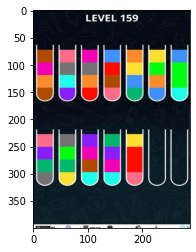

In [323]:
tubes_img = read_img("tubes.jpeg")
plt.imshow(tubes_img)
tubes = process_img("tubes.jpeg")

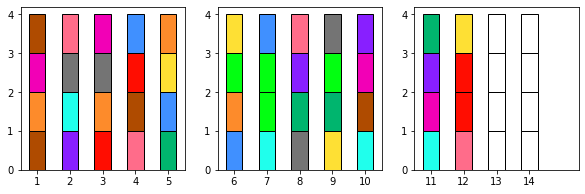

In [324]:
from colorsort_game import plot_tubes

plot_tubes(tubes)